In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import libraries

In [2]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 18.6 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.style.use('dark_background')

from statsmodels.tsa.stattools import adfuller  # kiểm tra chuỗi có tính dừng không -> có phụ thuộc vào thời gian chạy không?
from statsmodels.tsa.seasonal import seasonal_decompose   # phân tích -> thành phần chuỗi gốc, thành phần xu hướng, thành phần mùa vụ và thành phần nhiễu

from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

# Eval Function

In [4]:
def eval(test,pred,val,pred_val):
  print('** Testing **')
  test_mae = mean_absolute_error(test, pred)
  print('MAE: ', test_mae)

  test_ape = np.abs((test - pred) / test)
  test_mape = np.mean(test_ape) * 100
  print('MAPE: ', test_mape)

  test_mse = mean_squared_error(test, pred)
  test_rmse = np.sqrt(test_mse)
  print('RMSE: ', test_rmse)

  print('\n** Validate **')
  val_mae = mean_absolute_error(val, pred_val)
  print('MAE: ', val_mae)

  val_ape = np.abs((val - pred_val) / val)
  val_mape = np.mean(val_ape) * 100
  print('MAPE: ', val_mape)

  val_mse = mean_squared_error(val, pred_val)
  val_rmse = np.sqrt(val_mse)
  print('RMSE: ', val_rmse)

In [5]:
def test_stationarity(timeseries):

    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='yellow', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC') # tự động lựa chọn số lượng lag tối ưu dựa trên tiêu chí AIC ->
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

## Data

In [6]:
# 2. Đọc file csv
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/IMP.csv'
# company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/OPC.csv'
company_csv = '/content/drive/MyDrive/Colab Notebooks/Datacrawl/VMD.csv'
data = pd.read_csv(company_csv)
data

,Unnamed: 0,time,open,high,low,close,volume,ticker
0,0,2014-01-02,5980,6240,5980,6240,50,VMD
1,1,2014-01-03,6240,6240,6240,6240,100,VMD
2,2,2014-01-06,6340,6340,6340,6340,860,VMD
3,3,2014-01-07,6340,6340,6340,6340,0,VMD
4,4,2014-01-08,6090,6340,6090,6340,200,VMD
...,...,...,...,...,...,...,...,...
2472,2472,2023-12-04,20300,20300,19700,20300,238300,VMD
2473,2473,2023-12-05,20300,20900,19750,19900,62700,VMD
2474,2474,2023-12-06,20300,20600,20100,20150,51500,VMD
2475,2475,2023-12-07,20150,20300,20000,20150,41100,VMD


### Choose X

## Train, test, valid

In [7]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 6:3:1
df = pd.read_csv(company_csv)
df = df[['close']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets 6:3:1
train_size = int(0.6 * len(df))
test_size = int(0.3 * len(df))
val_size = len(df) - train_size - test_size

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

In [8]:
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['close'])

## Build model

### Choose p, q, d

In [9]:
model_autoARIMA = auto_arima(y_train,start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True,
                      exogenous= data[['high','open','low']][:len(y_train)])

model_autoARIMA.summary()

/usr/local/lib/python3.10/dist-packages/pmdarima/arima/_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=33013.482, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.39 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.92 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=22633.107, Time=1.52 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=22635.145, Time=2.31 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=22634.754, Time=2.67 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=2.91 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=1.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=22636.756, Time=3.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=22632.009, Time=0.69 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=27190.655, Time=2.74 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=1.76 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=22632.106, Time=2.49 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=22633.982, Time=1.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=28994.0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1486
Model:               SARIMAX(1, 0, 1)   Log Likelihood              -11312.004
Date:                Sat, 16 Dec 2023   AIC                          22632.009
Time:                        15:11:16   BIC                          22653.224
Sample:                             0   HQIC                         22639.916
                               - 1486                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    132.3491     32.189      4.112      0.000      69.260     195.438
ar.L1          0.9916      0.002    467.254      0.000       0.987       0.996
ma.L1         -0.0544      0.017     -3.172      0.002      -0.088      -0.021
sigma2      2.384e+05   6366.901     37.444      0.000    2.26e+05    2.51e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               198.07
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               2.57   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Build model

In [10]:
model = ARIMA(y_train, order=(1,0,1),exog=data[['high','open','low']][:len(y_train)]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1486
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -10193.777
Date:                Sat, 16 Dec 2023   AIC                          20401.554
Time:                        15:11:21   BIC                          20438.681
Sample:                             0   HQIC                         20415.392
                               - 1486                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         45.7594     38.145      1.200      0.230     -29.004     120.523
high           0.8079      0.011     70.769      0.000       0.786       0.830
open          -0.5356      0.012    -45.641      0.000      -0.559      -0.513
low            0.7249      0.014     51.822      0.000       0.697       0.752
ar.L1          0.1499      0.402      0.373      0.709      -0.638       0.938
ma.L1         -0.1021      0.404     -0.252      0.801      -0.895       0.690
sigma2      5.335e+04    949.662     56.175      0.000    5.15e+04    5.52e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             21058.72
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.97   Skew:                            -1.50
Prob(H) (two-sided):                  0.00   Kurtosis:                        21.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Eval

In [11]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['close'])
y_pred = model.predict(start=int(x_test[0]), end=int(len(x_test)+x_test[0]-1),exog=data[['high','open','low']][int(x_test[0]):int(len(x_test)+x_test[0])])


x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data['close'])
y_pred_val =  model.predict(start=int(x_val[0]), end=int(len(x_val)+x_val[0]-1),exog=data[['high','open','low']][len(x_train):(int(len(x_val)+x_val[0]))])

In [12]:
eval(y_test,y_pred,y_val,y_pred_val)

** Testing **
MAE:  239.24040572005302
MAPE:  0.9617163806497973
RMSE:  406.1399577312937

** Validate **
MAE:  216.01914658224433
MAPE:  1.0019865165353499
RMSE:  296.2483675430465


## Forecast

In [13]:
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)
# exogg = data[['high','open','low']][last_index-447:last_index].values.reshape(1341, 0)
# 1332 - 444 ; 1341 - 447; 1338 - 446
y_next_30_days = model.predict(start=int(x_next_30_days[0]), end=int(len(x_next_30_days)+x_next_30_days[0]-1),exog= data[['high','open','low']][last_index-1021:last_index])
#data[['high','open','low']][last_index-447:last_index]

print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
2477    18486.645786
2478    17915.092878
2479    17081.033386
2480    16497.660558
2481    16420.767555
2482    16134.998009
2483    16019.572981
2484    15589.741896
2485    15497.401874
2486    15822.901969
2487    16804.679800
2488    16782.282003
2489    16473.879371
2490    16550.765465
2491    16532.076957
2492    16296.837312
2493    16605.477299
2494    16817.638847
2495    16609.177615
2496    16816.476930
2497    16948.503986
2498    16592.776333
2499    16299.346996
2500    16570.853245
2501    17414.134860
2502    18993.858401
2503    19855.369697
2504    20376.378887
2505    20387.710280
2506    20153.173726
Name: predicted_mean, dtype: float64


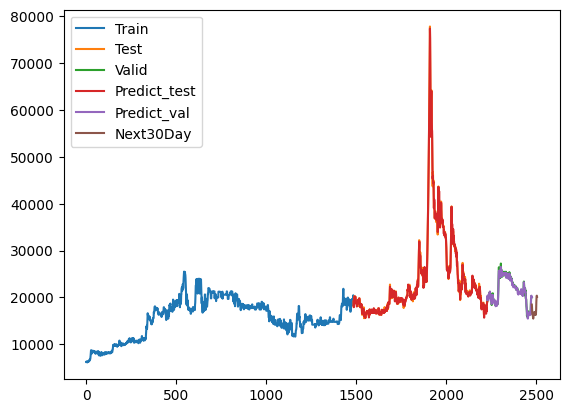

In [14]:
plt.plot(train_data.index, train_data['close'])
plt.plot(test_data.index, test_data['close'])
plt.plot(val_data.index, val_data['close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Valid', 'Predict_test','Predict_val','Next30Day'])
plt.show()